In [15]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
from PIL import Image
import torchvision
from torchvision import models,transforms

from Dataloaders.HAM10000Dataset import HAM10000Dataset
from functions import normalization, Model_functions

import time

import random
from PIL import Image
import cv2
import gc

**Load and normalize the data**

In [16]:
data = pd.read_csv('data_enum.csv')
data = data.sample(frac=1)
img_h, img_w = 224, 224

In [17]:
# norm_means, norm_std = compute_img_mean_std(data['image_path'],img_h,img_w)

norm_means = [0.77148203, 0.55764165, 0.58345652]
norm_std = [0.12655577, 0.14245141, 0.15189891]

In [18]:
# define the transformation of the train images.
transform = transforms.Compose([transforms.Resize((img_h,img_w)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_means, norm_std)])
# define the transformation of the val and test images.
val_test_transform = transforms.Compose([transforms.Resize((img_h,img_w)), transforms.ToTensor(),
                                        transforms.Normalize(norm_means, norm_std)])

In [19]:
train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_data, val_data = train_test_split(train_val_data, test_size=0.5, random_state=42)

train_dataset = HAM10000Dataset(train_data, transform=transform)
val_dataset = HAM10000Dataset(val_data, transform=transform)
test_dataset = HAM10000Dataset(test_data, transform=transform)

In [20]:
batch_size = 64 
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

print('Data len Train:', len(train_dataset), 'Val:', len(val_dataset), 'Test:', len(test_dataset))

Data len Train: 12362 Val: 12362 Test: 6181


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


# **Resnet**

In [22]:
model_temp = 'resnet_pret'
feature_extract = False
num_classes = 7
model_res = Model_functions.initialise_model(model_temp, num_classes, feature_extract, use_pretrained=True)
model_res.to(device)

/root/miniconda3/envs/DNN/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/DNN/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
input_size = (3, 224, 224)
print(summary(model_res, input_size, device=device.type))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         16,38

In [24]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_res.parameters(), lr=1e-3)

In [25]:
start_time = time.time()

In [26]:
epochs = 9 
patience = 5
model_filename = 'resnet_pret.pth'
resnet_model, total_loss_train, total_loss_val, total_acc_train, total_acc_val = Model_functions.train_and_validate_model(
                        model_res, train_loader, val_loader,test_loader, criterion,patience, optimizer, device, epochs, model_filename,verbose=True)

 11%|█         | 1/9 [01:41<13:32, 101.50s/it]

Epoch 1
Training Loss: 0.8926260001266125 
Training Accuracy: 67.15741789354473%
Validation Loss: 0.7501219681550547 
Validation Accuracy: 74.07377447015047%
Validation Loss Decreased(inf--->0.750122) 
Saving The Model


 22%|██▏       | 2/9 [03:30<12:20, 105.86s/it]

Epoch 2
Training Loss: 0.6091645404542845 
Training Accuracy: 78.01326646173759%
Validation Loss: 0.7897303858675908 
Validation Accuracy: 72.22132341045139%


 33%|███▎      | 3/9 [05:16<10:36, 106.09s/it]

Epoch 3
Training Loss: 0.5163987941041435 
Training Accuracy: 81.48357870894677%
Validation Loss: 0.5383095105284268 
Validation Accuracy: 80.69082672706682%
Validation Loss Decreased(0.750122--->0.538310) 
Saving The Model


 44%|████▍     | 4/9 [06:42<08:10, 98.19s/it] 

Epoch 4
Training Loss: 0.47053351084288864 
Training Accuracy: 83.04481475489403%
Validation Loss: 0.5707069404960907 
Validation Accuracy: 80.67464811519172%


 56%|█████▌    | 5/9 [08:25<06:38, 99.68s/it]

Epoch 5
Training Loss: 0.37477663097922337 
Training Accuracy: 86.60410936741627%
Validation Loss: 0.3879358369818668 
Validation Accuracy: 85.27746319365798%
Validation Loss Decreased(0.538310--->0.387936) 
Saving The Model


 67%|██████▋   | 6/9 [10:17<05:11, 103.94s/it]

Epoch 6
Training Loss: 0.3172401344576447 
Training Accuracy: 88.76395405274228%
Validation Loss: 0.4878457332241167 
Validation Accuracy: 83.09335059051934%


 78%|███████▊  | 7/9 [12:11<03:34, 107.15s/it]

Epoch 7
Training Loss: 0.3156934065993914 
Training Accuracy: 88.87720433586799%
Validation Loss: 0.36401683821813346 
Validation Accuracy: 86.59602006147873%
Validation Loss Decreased(0.387936--->0.364017) 
Saving The Model


 89%|████████▉ | 8/9 [14:00<01:47, 108.00s/it]

Epoch 8
Training Loss: 0.26756791351843123 
Training Accuracy: 90.5112441352532%
Validation Loss: 0.3278540825260054 
Validation Accuracy: 87.92266623523702%
Validation Loss Decreased(0.364017--->0.327854) 
Saving The Model


100%|██████████| 9/9 [15:41<00:00, 104.66s/it]

Epoch 9
Training Loss: 0.2318803750593023 
Training Accuracy: 91.90260475651189%
Validation Loss: 0.2560503319213071 
Validation Accuracy: 90.76201261931726%
Validation Loss Decreased(0.327854--->0.256050) 
Saving The Model


In [27]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total training and validation time for the Resnet Pretrainned Model: {total_time/60:.2f} minutes")
elapsed_time = end_time - start_time

Total training and validation time for the Resnet Pretrainned Model: 15.70 minutes


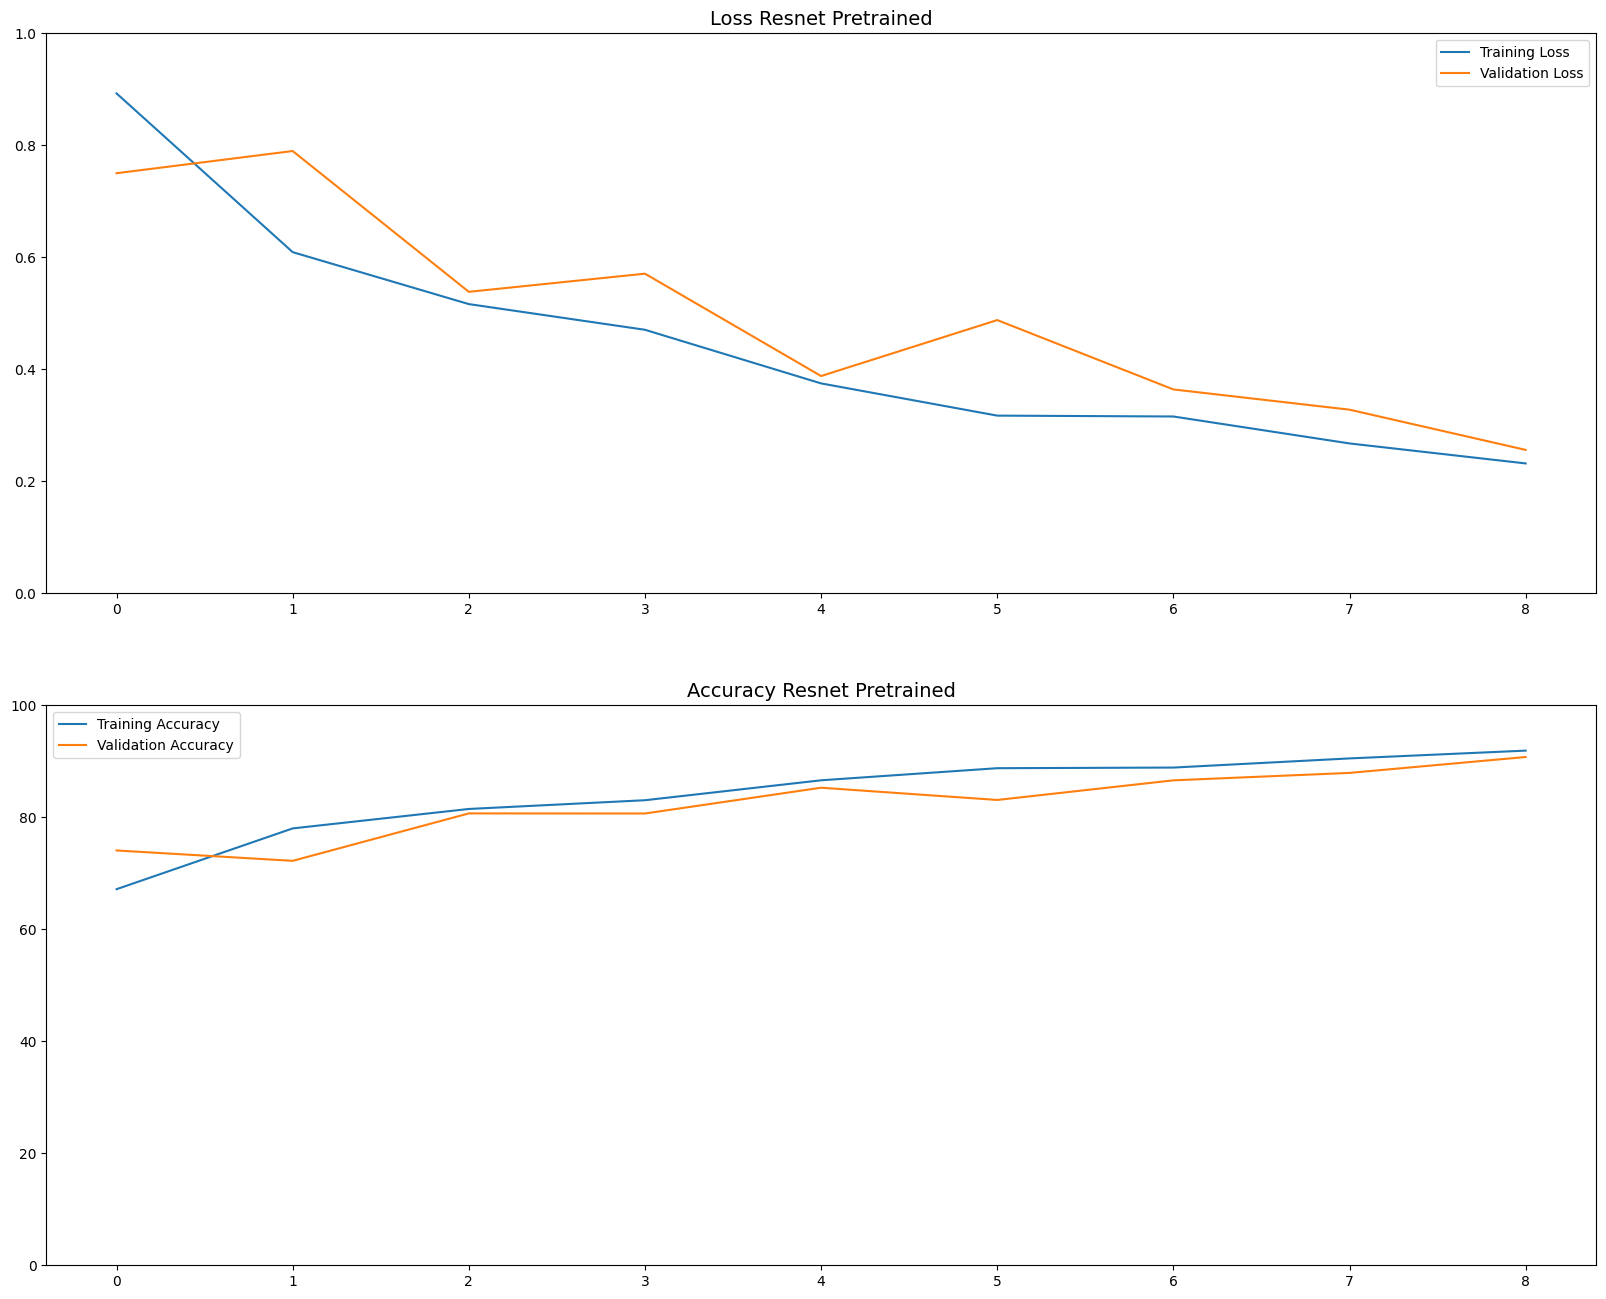

In [28]:
fig = plt.figure(num=2, figsize=(20, 16))  
fig1 = fig.add_subplot(2, 1, 1)
fig2 = fig.add_subplot(2, 1, 2)

fig1.plot(total_loss_train, label='Training Loss')
fig1.plot(total_loss_val, label='Validation Loss')
fig1.set_title('Loss Resnet Pretrained', fontsize=14)  
fig1.set_ylim([0, 1])
fig1.legend()
fig2.plot(total_acc_train, label='Training Accuracy')
fig2.plot(total_acc_val, label='Validation Accuracy')
fig2.set_ylim([0, 100])
fig2.set_title('Accuracy Resnet Pretrained', fontsize=14)  
fig2.legend()
plt.show()

In [29]:
start_time = time.time()
best_model_state = torch.load('resnet_pret.pth', map_location='cpu')
model_res.load_state_dict(best_model_state)
model_res.to('cpu')  
device = torch.device('cpu')
test_accuracy = Model_functions.test_model(model_res, test_loader, device)

infer_time = time.time() - start_time
print('-------------------------------------------------------')
print(f'Best model\'s accuracy: {test_accuracy}')
print(len(test_loader) , infer_time)
print('-------------------------------------------------------')


-------------------------------------------------------
Best model's accuracy: 91.58712182494742
97 218.1626741886139
-------------------------------------------------------


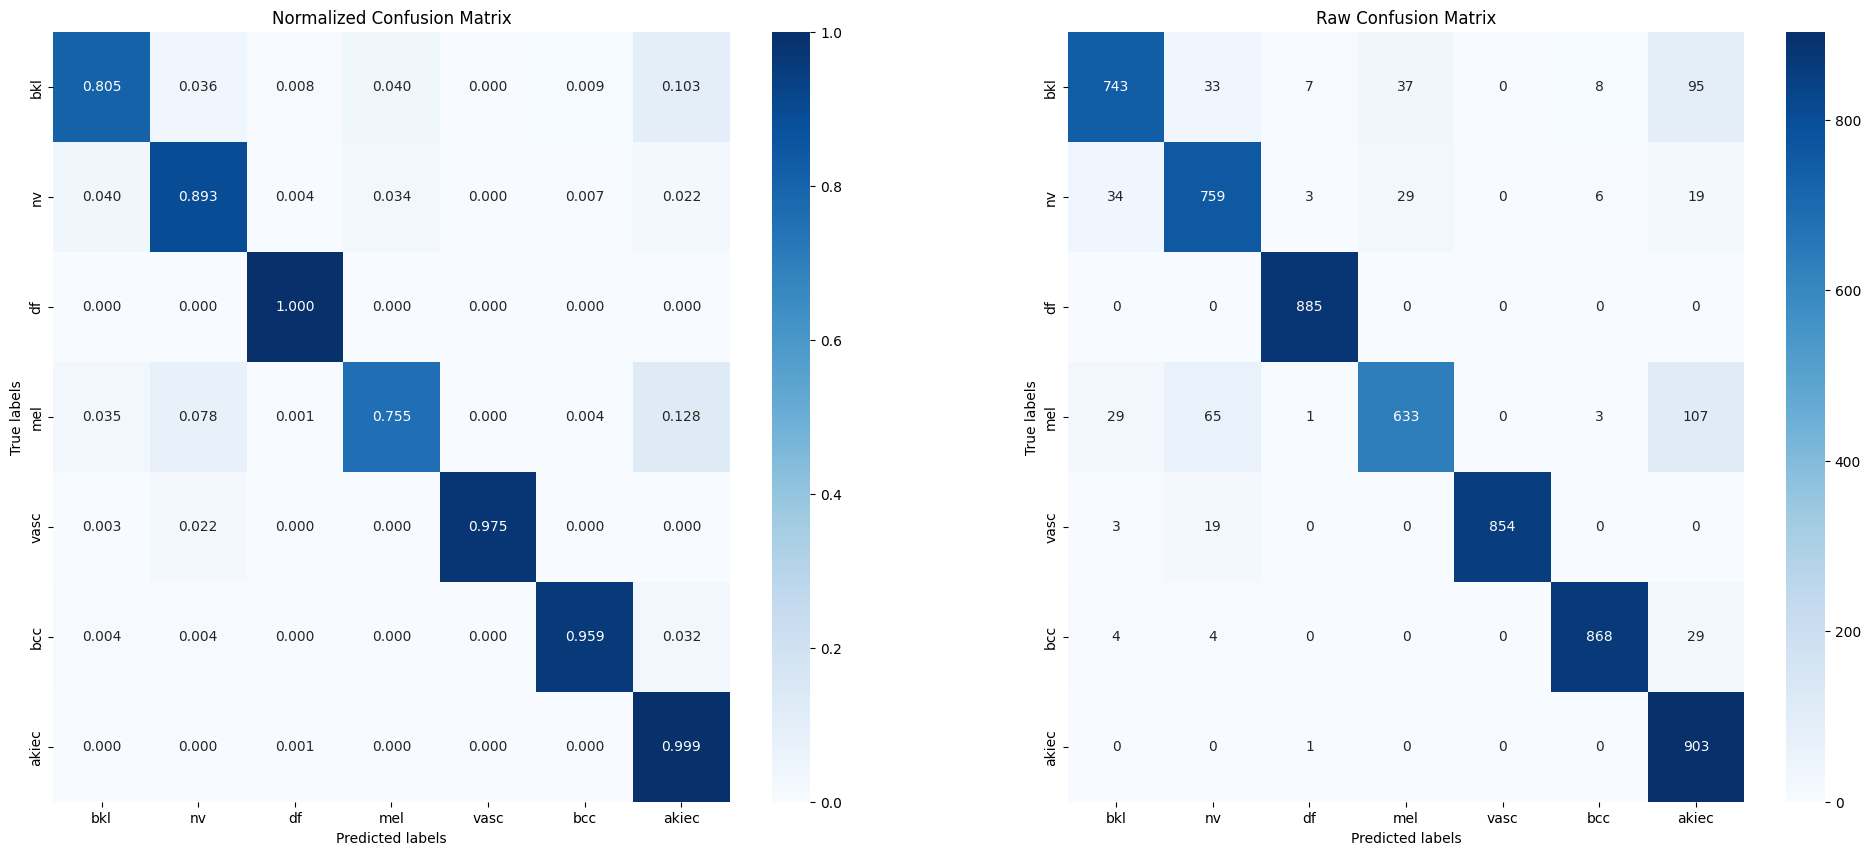

-------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

         bkl       0.91      0.80      0.86       923
          nv       0.86      0.89      0.88       850
          df       0.99      1.00      0.99       885
         mel       0.91      0.76      0.82       838
        vasc       1.00      0.97      0.99       876
         bcc       0.98      0.96      0.97       905
       akiec       0.78      1.00      0.88       904

    accuracy                           0.91      6181
   macro avg       0.92      0.91      0.91      6181
weighted avg       0.92      0.91      0.91      6181

-------------------------------------------------------


In [30]:
Model_functions.conf_report(model_res, test_loader, 'resnet_conf_mat')

**Empty the CUDA memory**

In [31]:
torch.cuda.empty_cache() 
gc.collect()

15252

In [32]:
# torch.cuda.memory_summary(device=None, abbreviated=False)

# **Densenet**

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [45]:
model_temp = 'densenet_pret'
num_classes = 7
feature_extract = False
model_des = Model_functions.initialise_model(model_temp, num_classes, feature_extract, use_pretrained=True)
model_des.to(device)

/root/miniconda3/envs/DNN/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/DNN/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [46]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_des.parameters(), lr=1e-3)

In [47]:
input_size = (3, 224, 224)
print(summary(model_des, input_size, device=device.type))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          45,440
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          49,600
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          53,760
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          57,920
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          62,080
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          66,240
|    └─_Transition: 2-6                  [-1, 128, 28, 28

In [48]:
start_time = time.time()

In [49]:
epochs = 8 
patience = 5
model_filename = 'densenet_pret.pth'
densenet_model, total_loss_train, total_loss_val, total_acc_train, total_acc_val = Model_functions.train_and_validate_model(
                        model_des, train_loader, val_loader,test_loader, criterion,patience, optimizer, device, epochs, model_filename,verbose=True)

 12%|█▎        | 1/8 [01:57<13:41, 117.42s/it]

Epoch 1
Training Loss: 0.7144721818646205 
Training Accuracy: 73.48325513670927%
Validation Loss: 0.5203992303499242 
Validation Accuracy: 80.86070215175538%
Validation Loss Decreased(inf--->0.520399) 
Saving The Model


 25%|██▌       | 2/8 [03:52<11:34, 115.75s/it]

Epoch 2
Training Loss: 0.4421058857871085 
Training Accuracy: 83.95890632583725%
Validation Loss: 0.3706355062649422 
Validation Accuracy: 86.29671574178936%
Validation Loss Decreased(0.520399--->0.370636) 
Saving The Model


 38%|███▊      | 3/8 [05:27<08:52, 106.49s/it]

Epoch 3
Training Loss: 0.3378730397095385 
Training Accuracy: 87.92266623523702%
Validation Loss: 0.36361241901351005 
Validation Accuracy: 87.92266623523702%
Validation Loss Decreased(0.370636--->0.363612) 
Saving The Model


 50%|█████     | 4/8 [07:21<07:17, 109.39s/it]

Epoch 4
Training Loss: 0.283283629406666 
Training Accuracy: 89.8560103543116%
Validation Loss: 0.2657187735834687 
Validation Accuracy: 90.58404788869115%
Validation Loss Decreased(0.363612--->0.265719) 
Saving The Model


 62%|██████▎   | 5/8 [09:23<05:41, 113.98s/it]

Epoch 5
Training Loss: 0.22892062435137858 
Training Accuracy: 91.88642614463679%
Validation Loss: 0.24681902830440974 
Validation Accuracy: 91.20692444588255%
Validation Loss Decreased(0.265719--->0.246819) 
Saving The Model


 75%|███████▌  | 6/8 [11:20<03:50, 115.10s/it]

Epoch 6
Training Loss: 0.19711145265123894 
Training Accuracy: 92.80860702151756%
Validation Loss: 0.2740465374183409 
Validation Accuracy: 89.86409966024915%


 88%|████████▊ | 7/8 [13:21<01:56, 116.81s/it]

Epoch 7
Training Loss: 0.17999303976515518 
Training Accuracy: 93.76314512214852%
Validation Loss: 0.18131148137305816 
Validation Accuracy: 93.81977026371138%
Validation Loss Decreased(0.246819--->0.181311) 
Saving The Model


100%|██████████| 8/8 [15:14<00:00, 114.30s/it]

Epoch 8
Training Loss: 0.15312340085577106 
Training Accuracy: 94.74195114059214%
Validation Loss: 0.39369951243771567 
Validation Accuracy: 88.65879307555412%


In [50]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total training and validation time for Pretrainned Densenet model: {total_time/60:.2f} minutes")

Total training and validation time for Pretrainned Densenet model: 15.26 minutes


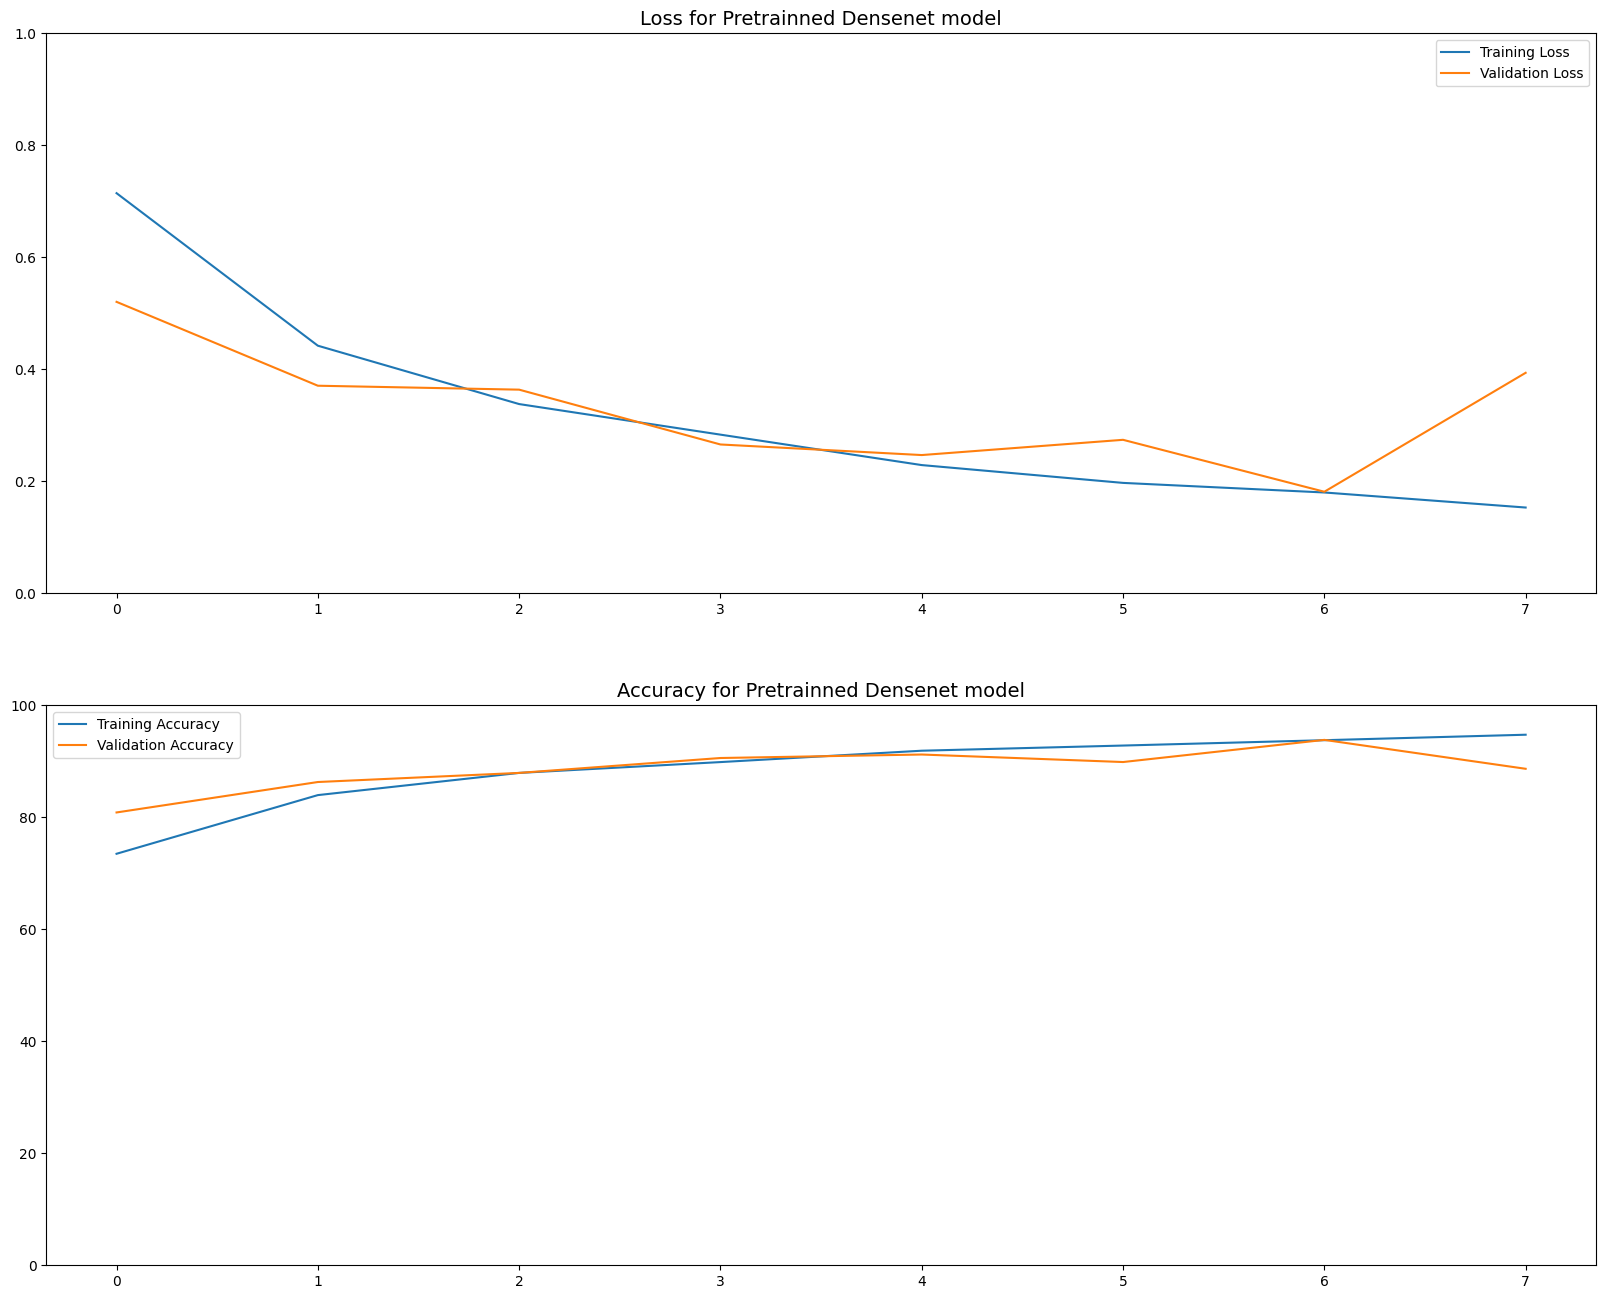

In [51]:
fig = plt.figure(num=2, figsize=(20, 16))  
fig1 = fig.add_subplot(2, 1, 1)
fig2 = fig.add_subplot(2, 1, 2)

fig1.plot(total_loss_train, label='Training Loss')
fig1.plot(total_loss_val, label='Validation Loss')
fig1.set_ylim([0, 1])
fig1.set_title('Loss for Pretrainned Densenet model', fontsize=14)  
fig1.legend()
fig2.plot(total_acc_train, label='Training Accuracy')
fig2.plot(total_acc_val, label='Validation Accuracy')
fig2.set_ylim([0, 100])
fig2.set_title('Accuracy for Pretrainned Densenet model', fontsize=14)  
fig2.legend()
plt.show()

In [52]:
best_model_state = torch.load('densenet_pret.pth',map_location='cpu')
device = torch.device('cpu')
model_des.load_state_dict(best_model_state)
model_des.to(device)

start_time = time.time()
test_accuracy = Model_functions.test_model(model_des, test_loader, device)
infer_time = time.time() - start_time
print('-------------------------------------------------------')
print(f'Best models accuracy {test_accuracy}')
print(len(test_loader),infer_time)
print('-------------------------------------------------------')

-------------------------------------------------------
Best models accuracy 93.94919915871218
97 90.02818155288696
-------------------------------------------------------


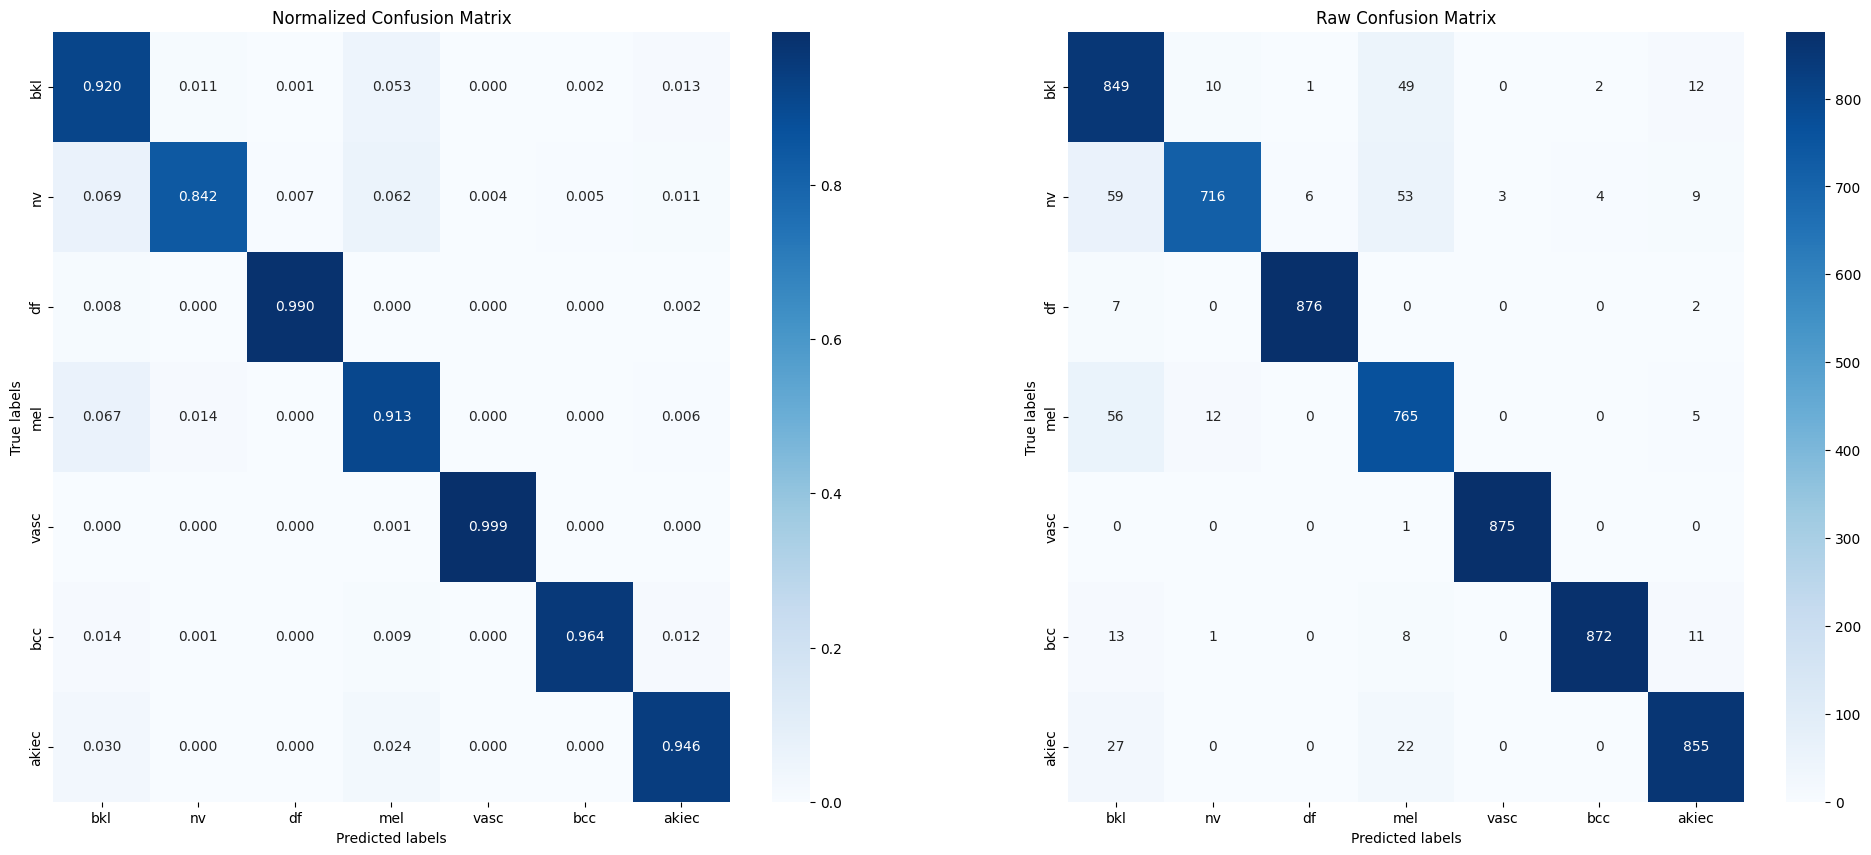

-------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

         bkl       0.84      0.92      0.88       923
          nv       0.97      0.84      0.90       850
          df       0.99      0.99      0.99       885
         mel       0.85      0.91      0.88       838
        vasc       1.00      1.00      1.00       876
         bcc       0.99      0.96      0.98       905
       akiec       0.96      0.95      0.95       904

    accuracy                           0.94      6181
   macro avg       0.94      0.94      0.94      6181
weighted avg       0.94      0.94      0.94      6181

-------------------------------------------------------


In [53]:
Model_functions.conf_report(model_des, test_loader, 'densenet_conf_mat')